### <span style="color: Orange">**XGBoost Model**</span>

- An end-to-end XGBoost workflow comparing the impact of feature engineering: config-driven data loading, parallel model training, stratified learning curves, cross-validated metrics, randomized hyperparameter search, permutation-based feature selection, and final model retraining on a combined feature set.

**Table of Contents**

- [Section I: Environment Setup and Configuration](#section-i-environment-setup-and-configuration)
- [Section II: Data Loading](#section-ii-data-loading)
- [Section III: Model Definition and Baseline Evaluation](#section-iii-model-definition-and-baseline-evaluation)
- [Section IV: Cross-Validation and Hyperparameter Tuning](#section-iv-cross-validation-and-hyperparameter-tuning)
- [Section V: Final Evaluation and Performance Reporting](#section-v-final-evaluation-and-performance-reporting)
- [Section VI: Feature Importance and Selection](#section-vi-feature-importance-and-selection)
- [Section VII: Final Model Training on Selected Features](#section-vii-final-model-training-on-selected-features)

**Notebook Introduction**

This notebook implements a rigorous XGBoost pipeline for breast cancer classification, emphasizing reproducibility and a direct comparison between models trained on raw versus engineered features. The workflow begins with a configuration-driven setup that loads distinct data splits. Parallel XGBoost models are initialized and first evaluated using stratified learning curves focused on malignant recall. This is followed by a robust, stratified cross-validation to establish baseline precision, recall, and F1 scores for both feature sets.

An extensive `RandomizedSearchCV` is then conducted for each model to find optimal hyperparameters, again prioritizing malignant recall. The tuned models are subsequently assessed with detailed classification reports on unseen validation and test data. Finally, permutation importance is used to identify the most influential features from both pipelines. These are combined into a final, consolidated feature set, which is used to train and evaluate a new, optimized XGBoost model, providing a clear conclusion on the value of feature engineering and selection.


### <span style="color: Orange;">**Section I: Environment Setup and Configuration**</span>

In this section, we begin by importing all the essential Python libraries required for our analysis. Following this, we load all the notebook-specific configurations from an external YAML file. This practice helps maintain a clean and organized workspace.

- **Library Imports:** We import standard data science libraries.
    - **Pandas** and **NumPy** are used for efficient data manipulation and numerical operations. &nbsp;
    - **Matplotlib** and **Seaborn** are included for data visualization, which will help us explore the data's underlying patterns and distributions. &nbsp;
- **Configuration Loading:** We use the `yaml` library to load configurations from `notebook_config.yaml`. &nbsp;
    - This file centrally stores the file paths for our various dataset splits (training, validation, and testing).
    - It defines paths for features (`X`) and labels (`y`) across different stages of processing: **raw**, **engineered**, and **final processed** data. &nbsp;

This setup ensures our notebook is modular, reproducible, and easy to manage, as all path dependencies are handled in a single configuration file.


In [17]:
# Importing all of the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
# Loading the notebook cofigurations
import yaml
with open("../notebook_config.yaml", "rb") as f:
    config = yaml.safe_load(f)
    X_train_eng, X_val_eng, X_test_eng = config['paths']["X_train_eng"], config['paths']["X_val_eng"], config['paths']["X_test_eng"]
    y_train_eng, y_val_eng, y_test_eng = config['paths']["y_train_eng"], config['paths']["y_val_eng"], config['paths']["y_test_eng"]
    
    X_train_raw, X_val_raw, X_test_raw = config['paths']["X_train_raw"], config['paths']["X_val_raw"], config['paths']["X_test_raw"]
    y_train_raw, y_val_raw, y_test_raw = config['paths']["y_train_raw"], config['paths']["y_val_raw"], config['paths']["y_test_raw"]

    X_train, X_val, X_test = config['paths']["X_train"], config['paths']["X_val"], config['paths']["X_test"]
    y_train, y_val, y_test = config['paths']["y_train"], config['paths']["y_val"], config['paths']["y_test"]

### <span style="color: Orange;">**Section II: Data Loading**</span>

In this section, we proceed to load all the dataset splits into memory. Using the file paths we defined in the configuration step, we read the corresponding CSV files into pandas DataFrames and Series.

- **Multiple Dataset Versions:** We load three distinct versions of the dataset to support different stages of the machine learning workflow:
    - **Raw Data (`*_raw`):** The original, unprocessed features and labels. This is useful for baseline comparisons and understanding the initial state of the data. &nbsp;
    - **Engineered Data (`*_eng`):** Datasets containing features that have undergone specific feature engineering steps. &nbsp;
    - **Processed Data:** The main, cleaned dataset that will be used for model training and evaluation. &nbsp;

- **Loading Features and Labels:** For each version, we load the training, validation, and test splits for both the features (`X`) and the corresponding labels (`y`).

- **Label Formatting:** The target variables (`y_train`, `y_val`, `y_test`) are loaded as CSVs and then converted into pandas Series using the `.squeeze()` method. This is a crucial step to ensure the label data is in the correct 1D format required by most machine learning libraries.

With all datasets now loaded into memory, we are ready to move on to exploratory data analysis and model building.

In [19]:
# Load engineered features and labels
X_train_eng = pd.read_csv(X_train_eng)
X_val_eng = pd.read_csv(X_val_eng)
X_test_eng = pd.read_csv(X_test_eng)
y_train_eng = pd.read_csv(y_train_eng).squeeze()
y_val_eng = pd.read_csv(y_val_eng).squeeze()
y_test_eng = pd.read_csv(y_test_eng).squeeze()

# Load raw features and labels
X_train_raw = pd.read_csv(X_train_raw)
X_val_raw = pd.read_csv(X_val_raw)
X_test_raw = pd.read_csv(X_test_raw)
y_train_raw = pd.read_csv(y_train_raw).squeeze()
y_val_raw = pd.read_csv(y_val_raw).squeeze()
y_test_raw = pd.read_csv(y_test_raw).squeeze()

# Load the main split as well
X_train = pd.read_csv(X_train)
X_val = pd.read_csv(X_val)
X_test = pd.read_csv(X_test)
y_train = pd.read_csv(y_train).squeeze()
y_val = pd.read_csv(y_val).squeeze()
y_test = pd.read_csv(y_test).squeeze()

### <span style="color: Orange;">**Section III: Model Definition and Baseline Evaluation**</span>

This section focuses on defining our classification models and establishing a baseline performance by analyzing their learning curves. We initialize two separate XGBoost classifiers to compare the impact of feature engineering.

- **Model Initialization:**
    - We define two XGBoost classifiers, `xgb_v1_eng` and `xgb_v1_raw`, with identical hyperparameters.
    - `xgb_v1_eng` will be trained on the **engineered features**, while `xgb_v1_raw` will be trained on the **raw features**. This setup allows for a direct comparison of the value added by our feature engineering process. &nbsp;

- **Learning Curve Visualization:**
    - A helper function, `plot_learning_curve`, is defined to visualize the model's performance as the training set size increases. This function helps diagnose issues like high bias or high variance.
    - It uses Scikit-learn's `learning_curve` to compute training and validation scores and Matplotlib to plot the results. &nbsp;

- **Custom Evaluation Metrics:**
    - Since standard accuracy can be misleading in datasets with class imbalance, we define custom scorers for **recall**, **precision**, and **F1-score** specifically for the positive class (labeled `1`, assumed to be "malignant").
    - A `StratifiedKFold` cross-validation strategy is employed to ensure that the proportion of classes is maintained in each fold, which is critical for reliable evaluation. &nbsp;

- **Performance Analysis:**
    - Finally, we generate and plot the learning curves for both the engineered and raw feature models using **recall for the malignant class** as our primary evaluation metric.
    - These plots provide an initial insight into how well each model learns from the data and whether the engineered features offer a tangible improvement in performance.


In [20]:
import xgboost as xgb

xgb_v1_eng = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=4,
    reg_alpha=0.5,
    reg_lambda=2,
    gamma=1,
    scale_pos_weight=1,  
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1
)
xgb_v1_raw = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=4,
    reg_alpha=0.5,
    reg_lambda=2,
    gamma=1,
    scale_pos_weight=1,  
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1
)

In [21]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, X_train, y_train, title, cv=5, scoring='accuracy'):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train, y_train, cv=cv, scoring=scoring,
        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1, random_state=42)
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(8,6))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label=f'Training {scoring}')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    plt.plot(train_sizes, val_mean, 'o-', color='green', label=f'Validation {scoring}')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='green')

    plt.title(title)
    plt.xlabel('Training Set Size')
    plt.ylabel(f'{scoring}')
    plt.legend()
    plt.grid(True)
    plt.show()

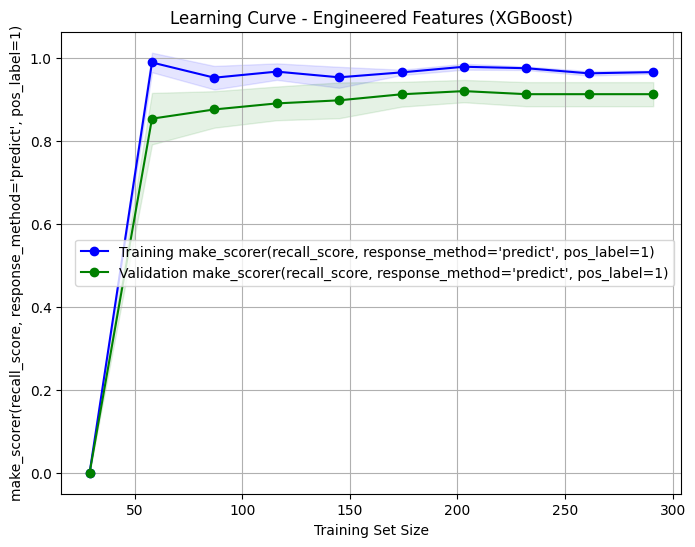

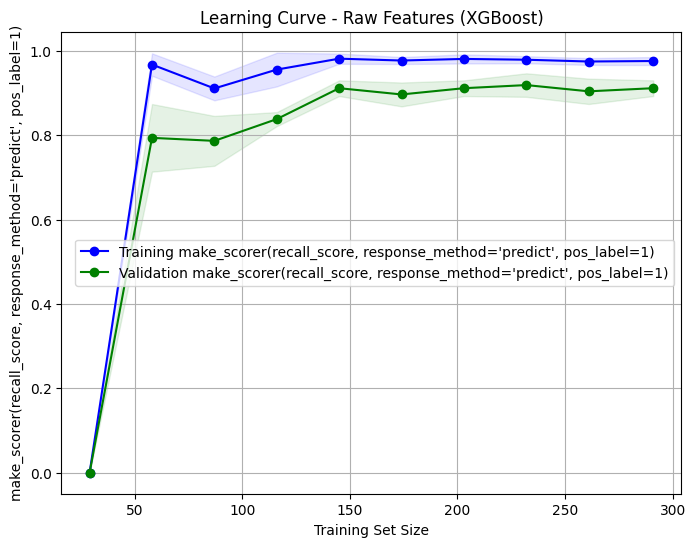

In [22]:
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score
from sklearn.model_selection import StratifiedKFold

recall_malignant = make_scorer(recall_score, pos_label=1)
precision_malignant = make_scorer(precision_score, pos_label=1)
f1_malignant = make_scorer(f1_score, pos_label=1)


stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
plot_learning_curve(
    xgb_v1_eng, X_train_eng, y_train_eng,
    'Learning Curve - Engineered Features (XGBoost)',
    cv=stratified_cv,
    scoring=recall_malignant
)
plot_learning_curve(
    xgb_v1_raw, X_train_raw, y_train_raw,
    'Learning Curve - Raw Features (XGBoost)',
    cv=stratified_cv,
    scoring=recall_malignant
)

### <span style="color: Orange;">**Section IV: Cross-Validation and Hyperparameter Tuning**</span>

In this section, we move from initial baseline analysis to a more rigorous evaluation and optimization of our models. We first use cross-validation to get a robust performance estimate for our baseline models and then employ `RandomizedSearchCV` to find the optimal hyperparameters.

- **Cross-Validation of Baseline Models:**
    - We use the `cross_validate` function with our `StratifiedKFold` strategy to evaluate the baseline XGBoost models (`xgb_v1_eng` and `xgb_v1_raw`).
    - This provides a more reliable performance assessment by averaging scores over multiple folds.
    - We calculate and print the mean and standard deviation for the **recall, precision, and F1-score** of the malignant class, establishing a clear quantitative baseline before optimization. &nbsp;

- **Hyperparameter Tuning with Randomized Search:**
    - To improve our models, we perform hyperparameter tuning using `RandomizedSearchCV`. This method efficiently searches a large parameter space by sampling a fixed number of combinations (`n_iter=50`).
    - A comprehensive parameter distribution (`param_dist`) is defined, covering key XGBoost hyperparameters like tree depth, learning rate, and regularization terms. &nbsp;

- **Optimization Strategy:**
    - The search is configured to evaluate models based on both **malignant and benign recall**, ensuring the tuner considers performance on both classes.
    - However, the `refit='recall_malignant'` parameter instructs the search to select the final best model based on the one that maximizes the recall for the malignant class, aligning with our primary goal of correctly identifying positive cases. &nbsp;

- **Execution and Final Model Selection:**
    - The `RandomizedSearchCV` is run independently on both the **engineered** and **raw** feature datasets.
    - After the search completes, the best-performing models (`best_xgb_eng` and `best_xgb_raw`) are saved as the `best_estimator_` attribute. These tuned models are now ready for final evaluation on the test set.


In [23]:
from sklearn.model_selection import cross_validate

scoring = {
    'recall_malignant': recall_malignant,
    'precision_malignant': precision_malignant,
    'f1_malignant': f1_malignant
}

cv_results_eng = cross_validate(
    xgb_v1_eng, X_train_eng, y_train_eng, 
    cv=stratified_cv, scoring=scoring, n_jobs=-1,
    return_train_score=False
)

cv_results_raw = cross_validate(
    xgb_v1_raw, X_train_raw, y_train_raw,
    cv=stratified_cv, scoring=scoring, n_jobs=-1,
    return_train_score=False
)
for metric in scoring.keys():
    scores = cv_results_eng[f'test_{metric}']
    print(f"Engineered Features - {metric}: {scores.mean():.3f} ± {scores.std():.3f}")
for metric in scoring.keys():
    scores = cv_results_raw[f'test_{metric}']
    print(f"Raw Features - {metric}: {scores.mean():.3f} ± {scores.std():.3f}")

Engineered Features - recall_malignant: 0.912 ± 0.029
Engineered Features - precision_malignant: 0.948 ± 0.037
Engineered Features - f1_malignant: 0.929 ± 0.021
Raw Features - recall_malignant: 0.912 ± 0.019
Raw Features - precision_malignant: 0.942 ± 0.049
Raw Features - f1_malignant: 0.926 ± 0.025


In [24]:
from sklearn.model_selection import RandomizedSearchCV

recall_benign = make_scorer(recall_score, pos_label=0)

scoring = {
    'recall_malignant': recall_malignant,
    'recall_benign': recall_benign
}

param_dist = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [2, 3, 4, 5, 6],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'subsample': [0.6, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.5, 1],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [1, 1.5, 2, 3],
    'scale_pos_weight': [0.65, 1, 1.5, 2],  
    'objective': ['binary:logistic'],
    'eval_metric': ['logloss'],
}

xgb_v1_eng = xgb.XGBClassifier(
    random_state=42,
    n_jobs=-1
)
xgb_v1_raw = xgb.XGBClassifier(
    random_state=42,
    n_jobs=-1
)

random_search_xgb_eng = RandomizedSearchCV(
    estimator=xgb_v1_eng,
    param_distributions=param_dist,
    n_iter=50,
    scoring=scoring,
    refit='recall_malignant',
    cv=stratified_cv,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search_xgb_eng.fit(X_train_eng, y_train_eng)
print("Best Parameters (Engineered):", random_search_xgb_eng.best_params_)

# Hyperparameter tuning for Raw Features
random_search_xgb_raw = RandomizedSearchCV(
    estimator=xgb_v1_raw,
    param_distributions=param_dist,
    n_iter=50,
    scoring=scoring,
    refit='recall_malignant',
    cv=stratified_cv,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search_xgb_raw.fit(X_train_raw, y_train_raw)
print("Best Parameters (Raw):", random_search_xgb_raw.best_params_)

best_xgb_eng = random_search_xgb_eng.best_estimator_
best_xgb_raw = random_search_xgb_raw.best_estimator_

results_xgb_eng = random_search_xgb_eng.cv_results_
results_xgb_raw = random_search_xgb_raw.cv_results_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters (Engineered): {'subsample': 0.8, 'scale_pos_weight': 2, 'reg_lambda': 2, 'reg_alpha': 0.1, 'objective': 'binary:logistic', 'n_estimators': 150, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 1, 'eval_metric': 'logloss', 'colsample_bytree': 0.8}
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters (Raw): {'subsample': 0.8, 'scale_pos_weight': 2, 'reg_lambda': 2, 'reg_alpha': 0.5, 'objective': 'binary:logistic', 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 0.1, 'eval_metric': 'logloss', 'colsample_bytree': 0.6}


### <span style="color: Orange;">**Section V: Final Evaluation and Performance Reporting**</span>

In this final section, we evaluate the performance of our best-tuned models on unseen data. The models, selected and optimized during the hyperparameter search, are now applied to both the validation and the final hold-out test sets. This step provides the ultimate measure of our models' generalization capabilities.

- **Model Performance Assessment:**
    - We use the `best_estimator_` attributes from our `RandomizedSearchCV` objects (`best_xgb_eng` and `best_xgb_raw`), which represent the models with the optimal hyperparameters.
    - These tuned models are used to make predictions on the validation and test splits for both the **engineered** and **raw** feature sets. &nbsp;

- **Generating Classification Reports:**
    - The primary tool for this evaluation is the `classification_report` from Scikit-learn.
    - This report provides a comprehensive breakdown of key metrics—**precision, recall, and F1-score**—for both the "Benign" and "Malignant" classes. It allows us to assess the model's performance on each class individually, which is crucial for imbalanced datasets. &nbsp;

- **Validation vs. Test Set Evaluation:**
    - We first generate reports for the **validation set** as a final sanity check to ensure the models are performing as expected after tuning.
    - Subsequently, we generate reports for the **test set**. Since this data has been completely held out throughout the entire training and tuning process, these results represent the most realistic and unbiased estimate of the models' real-world performance. &nbsp;

- **Final Comparison:**
    - By comparing the classification reports from the model trained on engineered features against the one trained on raw features, we can draw a definitive conclusion about the impact and effectiveness of our feature engineering efforts.


In [25]:
# Classification report on the Validation Splits
from sklearn.metrics import classification_report

# Predict on validation set with best estimator from engineered feature pool
y_val_pred_eng = best_xgb_eng.predict(X_val_eng)
print("Classification Report - Engineered Features Validation Set")
print(classification_report(y_val_eng, y_val_pred_eng, target_names=['Benign', 'Malignant']))

# Predict on test set with best estimator from engineered feature pool
y_test_pred_eng = best_xgb_eng.predict(X_test_eng)
print("Classification Report - Engineered Features Test Set")
print(classification_report(y_test_eng, y_test_pred_eng, target_names=['Benign', 'Malignant']))

Classification Report - Engineered Features Validation Set
              precision    recall  f1-score   support

      Benign       0.96      0.96      0.96        57
   Malignant       0.94      0.94      0.94        34

    accuracy                           0.96        91
   macro avg       0.95      0.95      0.95        91
weighted avg       0.96      0.96      0.96        91

Classification Report - Engineered Features Test Set
              precision    recall  f1-score   support

      Benign       0.97      1.00      0.99        72
   Malignant       1.00      0.95      0.98        42

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



In [26]:
# Predict on validation set with best estimator from raw feature pool
y_val_pred_raw = best_xgb_raw.predict(X_val_raw)
print("Classification Report - Raw Features Validation Set")
print(classification_report(y_val_raw, y_val_pred_raw, target_names=['Benign', 'Malignant']))

# Predict on test set with best estimator from raw feature pool
y_test_pred_raw = best_xgb_raw.predict(X_test_raw)
print("Classification Report - Raw Features Test Set")
print(classification_report(y_test_raw, y_test_pred_raw, target_names=['Benign', 'Malignant']))

Classification Report - Raw Features Validation Set
              precision    recall  f1-score   support

      Benign       0.96      0.96      0.96        57
   Malignant       0.94      0.94      0.94        34

    accuracy                           0.96        91
   macro avg       0.95      0.95      0.95        91
weighted avg       0.96      0.96      0.96        91

Classification Report - Raw Features Test Set
              precision    recall  f1-score   support

      Benign       0.99      0.99      0.99        72
   Malignant       0.98      0.98      0.98        42

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



### <span style="color: Orange;">**Section VI: Feature Importance and Selection**</span>

Having evaluated our models, we now delve into understanding *which features* are driving their predictions. For this, we use **Permutation Importance**, a powerful, model-agnostic technique that measures the influence of each feature by observing how model performance changes when that feature's values are randomly shuffled.

- **Calculating Permutation Importance:**
    - We use the `permutation_importance` function from Scikit-learn to compute feature importances for both our tuned models (`best_xgb_eng` and `best_xgb_raw`).
    - The calculation is performed on the **validation set** to provide an unbiased estimate of feature importance on unseen data.
    - The scoring metric is set to `accuracy`, meaning the importance value represents the decrease in accuracy when a feature is shuffled. This is repeated multiple times (`n_repeats=10`) for a more stable estimate. &nbsp;

- **Visualizing Importance:**
    - A custom helper function, `plot_perm_importances_hbar`, is defined to create clear and readable horizontal bar charts of the feature importances.
    - These plots allow for a quick visual comparison of the most influential features for both the engineered and raw datasets. &nbsp;

- **Automated Feature Selection:**
    - To move from analysis to action, we define a function `select_features_above_threshold_perm` that programmatically filters features based on an importance score threshold.
    - We apply this function to select the most impactful features from both the engineered and raw feature sets. &nbsp;

- **Creating a Combined Feature Set:**
    - Finally, we combine the selected features from both the raw and engineered model analyses into a single, unique list.
    - This consolidated set represents the most consistently important features identified across both modeling approaches and can be used to train a more focused, potentially more robust final model.


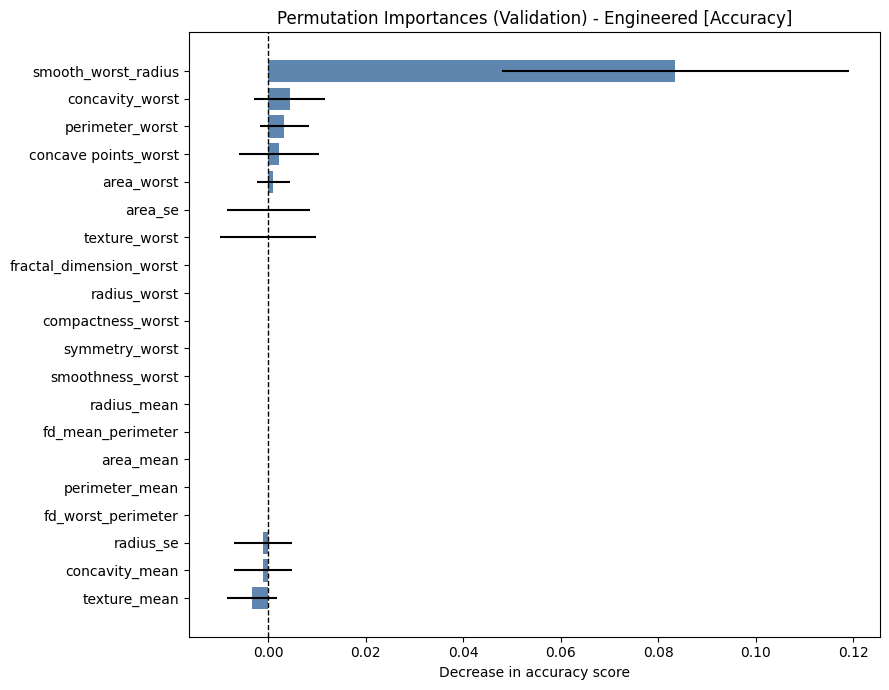

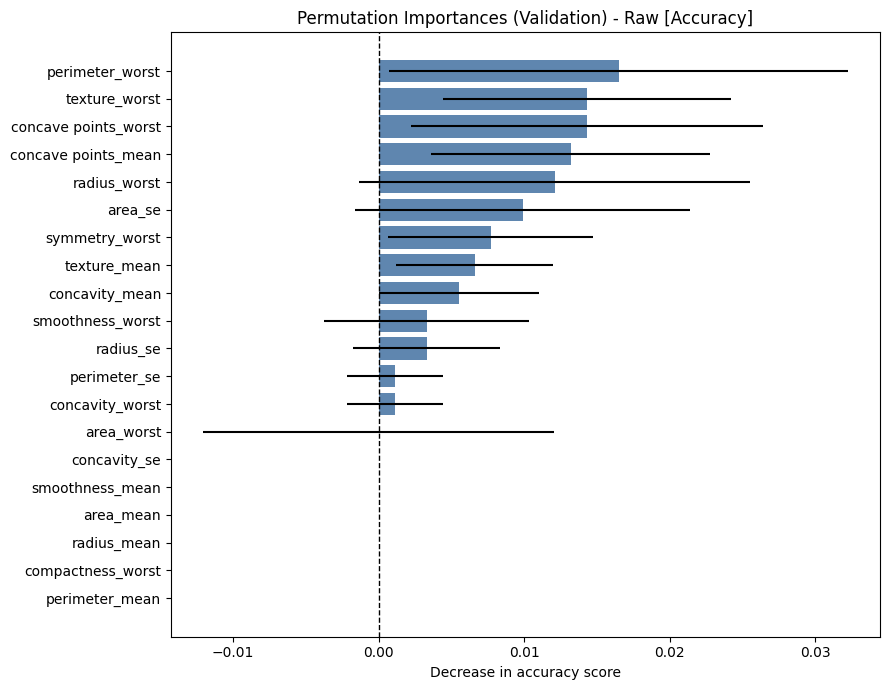

In [27]:
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt

def plot_perm_importances_hbar(importances_result, feature_names, title="Permutation Importances - Accuracy"):
    # Order features by mean importance (ascending for barh)
    imp_mean = importances_result.importances_mean
    imp_std  = importances_result.importances_std
    order = np.argsort(imp_mean)

    # Horizontal bar chart with error bars and zero line
    plt.figure(figsize=(9, max(6, 0.35*len(feature_names))))
    plt.barh(np.array(feature_names)[order], imp_mean[order], xerr=imp_std[order],
             color="#4e79a7", alpha=0.9)
    plt.axvline(0.0, color="k", linestyle="--", linewidth=1)
    plt.title(title)
    plt.xlabel("Decrease in accuracy score")
    plt.tight_layout()
    plt.show()

# Permutation importance for tuned XGBoost models (validation data)
perm_importance_eng = permutation_importance(
    best_xgb_eng, X_val_eng, y_val_eng,
    scoring='accuracy',
    # scoring=make_scorer(recall_score, pos_label=1),
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)
perm_importance_raw = permutation_importance(
    best_xgb_raw, X_val_raw, y_val_raw,
    # scoring=make_scorer(recall_score, pos_label=1),
    scoring='accuracy',
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# Plots (same horizontal style)
plot_perm_importances_hbar(perm_importance_eng, X_val_eng.columns,
                           "Permutation Importances (Validation) - Engineered [Accuracy]")
plot_perm_importances_hbar(perm_importance_raw, X_val_raw.columns,
                           "Permutation Importances (Validation) - Raw [Accuracy]")

In [28]:
def select_features_above_threshold_perm(perm_result, feature_names, threshold):
    importances = perm_result.importances_mean
    selected = [(feature, imp) for feature, imp in zip(feature_names, importances) if imp >= threshold]
    # Sort by importance descending
    selected_sorted = sorted(selected, key=lambda x: x[1], reverse=True)
    return selected_sorted

selected_eng = select_features_above_threshold_perm(perm_importance_eng, X_val_eng.columns, threshold=0.008)
print("Selected Engineered Features:", [f[0] for f in selected_eng])


selected_raw = select_features_above_threshold_perm(perm_importance_raw, X_val_raw.columns, threshold=0.008)
print("Selected Raw Features:", [f[0] for f in selected_raw])

combined_dict = {}

for feature, importance in selected_eng + selected_raw:
    if feature in combined_dict:
        combined_dict[feature] = max(combined_dict[feature], importance)
    else:
        combined_dict[feature] = importance

combined_sorted = sorted(combined_dict.items(), key=lambda x: x[1], reverse=True)
combined_features = [f[0] for f in combined_sorted]

print("Combined Unique Features:", len(combined_features))
print("Combined Features List:", combined_features)

Selected Engineered Features: ['smooth_worst_radius']
Selected Raw Features: ['perimeter_worst', 'texture_worst', 'concave points_worst', 'concave points_mean', 'radius_worst', 'area_se']
Combined Unique Features: 7
Combined Features List: ['smooth_worst_radius', 'perimeter_worst', 'texture_worst', 'concave points_worst', 'concave points_mean', 'radius_worst', 'area_se']


### <span style="color: Orange;">**Section VII: Final Model Training on Selected Features**</span>

In this concluding section, we build and evaluate a final, parsimonious model using only the most impactful features identified in the previous step. The goal is to determine if a simpler model can achieve competitive or even superior performance, which often leads to better generalization and interpretability.

- **Creating the Combined Feature Subset:**
    - We create new data splits (`X_train_combined`, `X_val_combined`, `X_test_combined`) by filtering the original datasets to include only the features present in our `combined_features` list.
    - This creates a focused dataset containing only the most relevant predictors. &nbsp;

- **Final Model Tuning:**
    - A new XGBoost classifier is initialized and subjected to the same `RandomizedSearchCV` process used before.
    - We use the same extensive hyperparameter grid and optimization strategy (`refit='recall_malignant'`) to find the best possible model for this reduced feature set. &nbsp;

- **Evaluation on Unseen Data:**
    - After the search identifies the best hyperparameters, the resulting optimal model (`best_svc_combined`) is used to make predictions on the held-out validation and test sets.
    - We generate and print final `classification_report`s for both the validation and test splits. &nbsp;

- **Concluding Assessment:**
    - The performance on the **test set** serves as the definitive measure of this feature-selected model's effectiveness. By comparing these results to the previous models, we can conclude whether our feature selection process successfully created a more efficient and effective final model.


In [29]:
X_train_combined = X_train[combined_features]
X_val_combined = X_val[combined_features]
X_test_combined = X_test[combined_features]
y_train_combined = y_train
y_val_combined = y_val
y_test_combined = y_test

In [30]:
param_dist = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [2, 3, 4, 5, 6],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'subsample': [0.6, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.5, 1],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [1, 1.5, 2, 3],
    'scale_pos_weight': [0.65, 1, 1.5, 2],  
    'objective': ['binary:logistic'],
    'eval_metric': ['logloss'],
}

xgb_combined = xgb.XGBClassifier(
    random_state=42,
    n_jobs=-1
)

random_search_combined = RandomizedSearchCV(
    estimator=xgb_combined,
    param_distributions=param_dist,
    n_iter=50,
    scoring=scoring,
    refit='recall_malignant',
    cv=stratified_cv,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search_combined.fit(X_train_combined, y_train_combined)

print("Best Hyperparameters:", random_search_combined.best_params_)
best_svc_combined = random_search_combined.best_estimator_

y_val_pred = best_svc_combined.predict(X_val_combined)
print("Validation Classification Report:\n", classification_report(y_val_combined, y_val_pred, target_names=['Benign', 'Malignant']))

y_test_pred = best_svc_combined.predict(X_test_combined)
print("Test Classification Report:\n", classification_report(y_test_combined, y_test_pred, target_names=['Benign', 'Malignant']))


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters: {'subsample': 0.7, 'scale_pos_weight': 2, 'reg_lambda': 3, 'reg_alpha': 0.5, 'objective': 'binary:logistic', 'n_estimators': 150, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0, 'eval_metric': 'logloss', 'colsample_bytree': 0.6}
Validation Classification Report:
               precision    recall  f1-score   support

      Benign       0.96      0.95      0.96        57
   Malignant       0.91      0.94      0.93        34

    accuracy                           0.95        91
   macro avg       0.94      0.94      0.94        91
weighted avg       0.95      0.95      0.95        91

Test Classification Report:
               precision    recall  f1-score   support

      Benign       0.97      1.00      0.99        72
   Malignant       1.00      0.95      0.98        42

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114